<div style="text-align: right;">
<a target="_blank" href="https://colab.research.google.com/github/hkaragah/hkaragah.github.io/blob/main/structure/moment_curvature/steel_w_sec_moment_curvature.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<div style="font-size: 0.8em; color: #555;">By Hossein Karagah</div>
<div style="font-size: 0.8em; color: #555;">© Copyright 2025 GNU GENERAL PUBLIC LICENSE.</div>
</div>

## Setup Notebook

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../.."))
from assets.modules.materials import *
from assets.modules.steel import *
from assets.modules.shapes import *
from assets.modules.analysis import *
import assets.modules.concrete as concrete
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from matplotlib.patches import Rectangle
from matplotlib.patches import bbox_artist

## Define Beams, columns, and Joints

### 1. Define Materials

In [2]:
# Define materials
con_5000 = ACIConcrete(fc=5000, is_lightweight=False, density=150 / 12**3)
mild_steel = BilinearSteel("A706", fy=60000)
pt_steel = PrestressingA416Strand()

### 2. Define Beams, Columns, and joints

In [3]:
# Number of spans
n_spans = 2

# Define lower and upper columns
lower_cols, upper_cols = [], []
for i in range(n_spans + 1):
    lower_cols.append(ConcreteColumn(length=11+4/12, width=24/12, depth=24/12, mat=con_5000))
    upper_cols.append(ConcreteColumn(length=11+4/12, width=24/12, depth=24/12, mat=con_5000))

# Define beams
beam_lengths = [62, 44]
beams: list[ConcreteTSectionBeam] = []
for length in beam_lengths:
    beams.append(ConcreteTSectionBeam(length=length, width=15/12, depth=36/12, flange_width=95/12, flange_thickness=5/12, mat=con_5000))

# Define joints
joints = []
for i in range(n_spans + 1):
    left_beam = None if i == 0 else beams[i-1]
    right_beam = None if i == n_spans else beams[i]
    joints.append(Concrete2DJoint(left_beam, right_beam, lower_cols[i], upper_cols[i]))
    
print("Defined Columns:")
for col in lower_cols + upper_cols:
    print(col)
    
print("\nDefined Beams:")
for beam in beams:
    print(beam)
    
print("\nDefined Joints:")
for joint in joints:
    print(joint)


Defined Columns:
Column C1 @ J1 [height=11.33', 24.0" x 24.0"]
Column C3 @ J2 [height=11.33', 24.0" x 24.0"]
Column C5 @ J3 [height=11.33', 24.0" x 24.0"]
Column C2 @ J1 [height=11.33', 24.0" x 24.0"]
Column C4 @ J2 [height=11.33', 24.0" x 24.0"]
Column C6 @ J3 [height=11.33', 24.0" x 24.0"]

Defined Beams:
T-Beam B1 @ J1 --> J2 [length=62.00', web: 15.0" x 36.0", flange: 95.0" x 5.0"]
T-Beam B2 @ J2 --> J3 [length=44.00', web: 15.0" x 36.0", flange: 95.0" x 5.0"]

Defined Joints:
2D Joint J1 @ None← →B1, C1↓ ↑C2
2D Joint J2 @ B1← →B2, C3↓ ↑C4
2D Joint J3 @ B2← →None, C5↓ ↑C6


## Compute Beam Section Properties

Both spans have the same section.

In [4]:
# Beam section properties

# Beam area
A = beams[0].sec.area * 12**2 # ft^2
print(f"A={A:.0f} in^2")

# Beam moment of inertia
I = beams[0].sec.moment_inertia()[0] * 12**4 # in^4
print(f"I={I:.0f} in^4")

# Beam centroid relait veo the top and bottom and top of the beam
yt = beams[0].sec.yt * 12 # in
yb =  beams[0].sec.yb * 12 # in
print(f"yt={yt:.1f} in")
print(f"yb={yb:.1f} in")

# Beam section modulus
S_t = I / yt # in^3
S_b = I / yb # in^3
print(f"St={S_t:.0f} in^3")
print(f"Sb={S_b:.0f} in^3")

A=940 in^2
I=114360 in^4
yt=11.4 in
yb=24.6 in
St=10028 in^3
Sb=4650 in^3


## Define Loads

* Both spans have the same 15"x36" beam cast monolitically with the slab creating a T-section.
* Beams are repated @ 18-ft o.c.
* For the live load assume standard parking loading

In [5]:
# Compute area loads
concrete_density = con_5000.density * (12**3/1e3) # k/ft^3

slab_thickness = 5/12 # ft
slab_load = slab_thickness *  concrete_density# k/ft^2

beam_spacing = 18 # ft
beam_sec: ConcreteTSectionBeam = beams[0]
beam_load = (beam_sec.depth - slab_thickness) * beam_sec.width * concrete_density / beam_spacing # k/ft^2

superimposed_dead_load = 2 / 1e3 # k/ft^2

concrete_load = slab_load + beam_load # k/ft^2
dead_load = concrete_load + superimposed_dead_load # k/ft^2
live_load = 40 / 1e3 # k/ft^2

print(f"Concrete load: {concrete_load:.3f} k/ft^2")
print(f"Dead load: {dead_load:.3f} k/ft^2")
print(f"Live load: {live_load:.3f} k/ft^2\n")

# Compute beam loads
w_conc = concrete_load * beam_spacing # k/ft
w_dead = dead_load * beam_spacing # k/ft
w_live = live_load * beam_spacing # k/ft

print(f"w_conc = {w_conc:.3f} k/ft")
print(f"w_dead = {w_dead:.3f} k/ft")
print(f"w_live = {w_live:.3f} k/ft\n")

# Compute factored loads
w_ud = 1.2 * w_dead # k/ft
w_ul = 1.6 * w_live # k/ft
w_u = w_ud + w_ul # k/ft

print(f"w_ud = {w_ud:.3f} k/ft")
print(f"w_ul = {w_ul:.3f} k/ft")
print(f"w_u = {w_u:.3f} k/ft\n")


Concrete load: 0.089 k/ft^2
Dead load: 0.091 k/ft^2
Live load: 0.040 k/ft^2

w_conc = 1.609 k/ft
w_dead = 1.645 k/ft
w_live = 0.720 k/ft

w_ud = 1.974 k/ft
w_ul = 1.152 k/ft
w_u = 3.126 k/ft



---

## Prestressing Tendons

### 1. Compute Prestressing Force

Balacing approximately 70% of concrete load in each span and proviing a minimum of 250 psi average prestressing compression.


In [6]:
min_comp_stress = 250 /1e3 # ksi
balance_factor = 0.7

# Distance between the lowest point of the tendon to the bottom of the beam in span A-B
low_ab = 4 # in

# Distance between the highest point of tendon to the top of the beam at mid-support B
high_b = 4 # in

# Beam: A-----B-----C
# Center of gravity of strand profile (c.g.s.) from the top of the beam
cgs_a = yt # in
cgs_ab = beam_sec.depth * 12 - low_ab # in
cgs_b = high_b # in

# Compute prestressing force to balance 70% of concrete load
l_ab = beams[0].length # ft
ecc_ab = cgs_ab - (cgs_a + cgs_b) / 2 # in
w_eq_ab = balance_factor * w_conc
F_min = min_comp_stress * (beams[0].sec.area * 12**2) # kips
F = max(F_min, (w_eq_ab * l_ab**2 / 8) / (ecc_ab / 12)) # kips
print(f"a={ecc_ab:.1f} in")
print(f"F={F:.0f} kips ≥ Fmin={F_min:.0f} kips\n")

a=24.3 in
F=267 kips ≥ Fmin=235 kips



### 2. Compute Number of Strands

* Assume 1/2"-strands with the area of 0.153 in² and $f_{pu}=270\ ksi$.
* Assume $15\ ksi$ prestressing loss.

In [7]:
# Define prestessing strand properties
strand = Prestressing7WireStrand(dia=1/2, mat=pt_steel)

# Mechanical properties of prestressing strand
fpu = strand.mat.fpu/1e3 # ksi
pt_loss = 15 # ksi, prestressing loss
fpy = strand.mat.fpy # ksi
fse = 0.7 * fpu - pt_loss # ksi

# Compute number of required strands
n_strands = F / (strand.area * fse)
n_strands = int(np.floor(n_strands))
Aps = n_strands * strand.area # in^2

# Acutal prestressing force
F = n_strands * strand.area * fse # kips
print(f"Number of 1/2\"-strands: {n_strands} (Aps={Aps:.3f} in^2)")
print(f"Provided prestressing force: F={F:.1f} kips")

# Define prestressing tendon properties
tendon = PrestressingTendon(strand, n_strands)


Number of 1/2"-strands: 10 (Aps=1.530 in^2)
Provided prestressing force: F=266.2 kips


### 3.Compute Drape in Shorter Span

Using the prestressing force and number of strands determined in the previous section, I calculate the drape in the middle of the second span to balance 70% of the concrete load.

In [8]:
# Beam: A-----B-----C
l_bc = beams[1].length # ft
ecc_bc = (w_eq_ab * l_bc**2 / 8) / F * 12 # in
cgs_c = yt  # in
cgs_bc = ecc_bc + (cgs_b + cgs_c) / 2 # in

# Distance between the lowest point of the tendon to the bottom of the beam in span B-C
low_bc = beams[1].depth * 12 - cgs_bc # in

print(f"Distance from lowest point of tendon to bottom of beam BC: {low_bc:.1f} in")

Distance from lowest point of tendon to bottom of beam BC: 16.0 in


### 4.Strand Profile

Strand profile (A-B): y = 0.0251x^2 + -1.4390x + 0.0000 (extreme at x=28.6 ft, y=-20.6 in)
Strand profile (B-C): y = 0.0248x^2 + -4.3347x + 180.8258 (extreme at x=87.4 ft, y=-8.6 in)


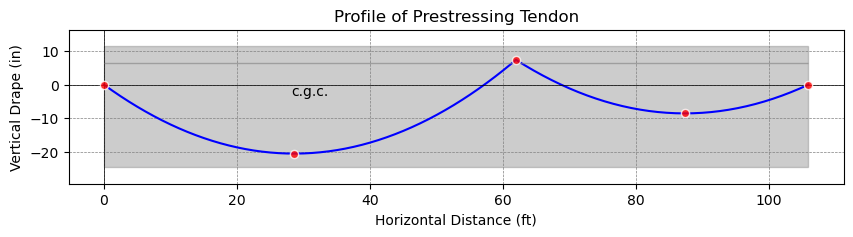

In [9]:
# Define end points of the tendon profile
p_a = Point(0, 0) # at c.g.c.
p_b = Point(beams[0].length, beams[0].sec.yt*12 - high_b)
p_c = Point(beams[0].length + beams[1].length, 0) # at c.g.c.

# Define minimum ordinate of the tendon given the drape
y_ext_ab = -(beams[0].sec.yb * 12 - low_ab) # in
y_ext_bc = -(beams[1].sec.yb * 12 - low_bc) # in

# Compute the parabolic profile of the tendon in span A-B and B-C
a1, b1, c1 = parabola_from_points(p_a, p_b, y_ext_ab)
a2, b2, c2 = parabola_from_points(p_b, p_c, y_ext_bc)

# Compute extreme point's abscissa and ordinate using calculated parabola coefficients
x_ext_ab = -b1 / (2 * a1) # ft, in span A-B
y_ext_ab_calc = a1 * x_ext_ab**2 + b1 * x_ext_ab + c1

x_ext_bc = -b2 / (2 * a2) # ft, in span B-C
y_ext_bc_calc = a2 * x_ext_bc**2 + b2 * x_ext_bc + c2

print(f"Strand profile (A-B): y = {a1:.4f}x^2 + {b1:.4f}x + {c1:.4f} (extreme at x={x_ext_ab:.1f} ft, y={y_ext_ab_calc:.1f} in)")
print(f"Strand profile (B-C): y = {a2:.4f}x^2 + {b2:.4f}x + {c2:.4f} (extreme at x={x_ext_bc:.1f} ft, y={y_ext_bc_calc:.1f} in)")

# Generate (x, y) points for plotting the tendon profile
x_vals_ab = np.linspace(min(p_a.x, p_b.x), max(p_a.x, p_b.x), 100)
y_vals_ab = a1 * x_vals_ab**2 + b1 * x_vals_ab + c1

x_vals_bc = np.linspace(min(p_b.x, p_c.x), max(p_b.x, p_c.x), 100)
y_vals_bc = a2 * x_vals_bc**2 + b2 * x_vals_bc + c2

x_vals = np.concatenate([x_vals_ab, x_vals_bc])
y_vals = np.concatenate([y_vals_ab, y_vals_bc])

# Plot the tendon profile
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(x_vals, y_vals, label='Parabolic Strand Profile', color='blue')
ax.scatter([p_a.x, p_b.x, p_c.x, x_ext_ab, x_ext_bc],
           [p_a.y, p_b.y, p_c.y, y_ext_ab_calc, y_ext_bc_calc], s=35, c='red', edgecolors='white', linewidths=1.0, alpha=0.8, zorder=5)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.text((p_a.x + p_b.x) / 2, p_a.y, "c.g.c.", fontsize=10, va='top', ha='center')

# --- Rectangle spanning the two-beam length and section depth ---
total_len = beams[0].length + beams[1].length
y_min = -beams[0].sec.yb * 12 # in
y_max =  beams[0].sec.yt * 12 # in
rect = Rectangle((0.0, y_min), total_len, y_max - y_min,
                 edgecolor='grey', facecolor='grey', alpha=0.4, linewidth=1.0)
ax.add_patch(rect)
ax.hlines(y=y_max - beams[0].flange_thickness*12, xmin=0, xmax=total_len, color='grey', linewidth=1.0, alpha=0.6,)
# ---------------------------------------------------------------
ax.set_ylim(y_min - 5, y_max + 5)
ax.set_xlabel('Horizontal Distance (ft)')
ax.set_ylabel('Vertical Drape (in)')
ax.set_title('Profile of Prestressing Tendon')
ax.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

### 5.Determine Actual Prestressing Equivalent Loads

In [10]:
w_eq_ab = -8 * F * (ecc_ab / 12) / (l_ab**2) # k/ft, upward negative
w_eq_bc = -8 * F * (ecc_bc / 12) / (l_bc**2) # k/ft, upward negative

print(f"{'Span':<7}{'w_eq (klf)':<16}{'a (in)':<10}{'mid-span drape (in)':<15}")
print(f"{'-'*7:<7}{'-'*15:<15}{'-'*15:<15}{'-'*15:<15}")
print(f"{'AB':<7}{w_eq_ab:.3f} ({100*abs(w_eq_ab/w_conc):.1f}{'%)':<5}{ecc_ab:<10.3f}{beams[0].depth * 12 - cgs_ab:<15.3f}")
print(f"{'BC':<7}{w_eq_bc:.3f} ({100*abs(w_eq_bc/w_conc):.1f}{'%)':<5}{ecc_bc:<10.3f}{beams[1].depth * 12 - cgs_bc:<15.3f}")

Span   w_eq (klf)      a (in)    mid-span drape (in)
----------------------------------------------------
AB     -1.122 (69.7%)   24.298    4.000          
BC     -1.127 (70.0%)   12.289    16.009         


---
## Analyze Beams

### 1.Compute Distribution Factors, Carry-Over Factors, and Fixed-End Moments

In [11]:
import pandas as pd

# Build DataFrame with joint + element association
df = pd.DataFrame({
    "Joint ID": [j.id for j in joints for e in j._elements],
    "Element ID": [e.id for j in joints for e in j._elements],
    "Stiffness": [j.stiffness_factors[e.id] for j in joints for e in j._elements],
    "Distribution": [j.distribution_factors[e.id] for j in joints for e in j._elements],
    "Carry-Over": [j.carry_over_factors[e.id] for j in joints for e in j._elements]
})

# Group by Joint ID
grouped = df.groupby("Joint ID")

for joint_id, group in grouped:
    print(f"\nJoint {joint_id}")
    print(group)


# grouped_df = grouped.apply(lambda g: g).drop("Joint ID", axis=1)



Joint J1
  Joint ID Element ID      Stiffness  Distribution  Carry-Over
0       J1         B1  224239.964792      0.189091    0.524187
1       J1         C2  480820.475546      0.405454    0.477149
2       J1         C1  480820.475546      0.405454    0.477149

Joint J2
  Joint ID Element ID      Stiffness  Distribution  Carry-Over
3       J2         B1  224239.964792      0.148207    0.524187
4       J2         B2  327139.638317      0.216216    0.534073
5       J2         C4  480820.475546      0.317788    0.477149
6       J2         C3  480820.475546      0.317788    0.477149

Joint J3
  Joint ID Element ID      Stiffness  Distribution  Carry-Over
7       J3         B2  327139.638317      0.253837    0.534073
8       J3         C6  480820.475546      0.373082    0.477149
9       J3         C5  480820.475546      0.373082    0.477149


### 2.Fixed-End Moments

In [12]:
# Compute fixed-end moments for each beam under dead, live, and equivalent prestressing loads
loads = {
    "Dead": [w_dead, w_dead],
    "Live": [w_live, w_live],
    "Equivalent": [w_eq_ab, w_eq_bc]
}

FEM = {}
for i, beam in enumerate(beams):
    for load_name, load_value in loads.items():
        M_A, M_B = get_fixed_end_moment_uniform_load(
            uniform_load=load_value[i],
            length=beam.length,
            left_rigid_length=beam.start_rigid_length,
            right_rigid_length=beam.end_rigid_length
        )
        FEM[(beam.id, load_name)] = (M_A, M_B)
        
fem_df = pd.DataFrame.from_dict(
    FEM, 
    orient='index', 
    columns=['FEM_left (k-ft)', 'FEM_right (k-ft)']
)

fem_df


,FEM_left (k-ft),FEM_right (k-ft)
"(B1, Dead)",543.796438,-543.796438
"(B1, Live)",237.960000,-237.960000
"(B1, Equivalent)",-370.770994,370.770994
"(B2, Dead)",277.245688,-277.245688
"(B2, Live)",121.320000,-121.320000
"(B2, Equivalent)",-189.825781,189.825781


### 3.Service Loads Shears and Moments

In [13]:
# Define uniform loads for each load case, units in k/ft, downward positive
uniform_loads = {
    "Dead":{"B1": w_dead, "B2": w_dead},
    "Live":{"B1": w_live, "B2": w_live},
    "Equivalent":{"B1": w_eq_ab, "B2": w_eq_bc}
}

# Beam end moments obtained from moment distribution analysis
# Units in k-ft, ccw positive, (M_left, M_right)
end_moments = {
    "Dead": {"B1": (459.2, -556.9), "B2": (372.7, -182.0)},
    "Live": {"B1": (201.0, -243.7), "B2": (163.1, -79.7)},
    "Equivalent": {"B1": (-313.1, 380.0), "B2": (-255.1, 125.0)}
}

N_POINTS = 15
n_beams = len(beams)
load_cases = list(uniform_loads.keys())

# Collect per-beam arrays in lists first
X_rows = [None] * n_beams
V = {lc: [None] * n_beams for lc in load_cases}
M = {lc: [None] * n_beams for lc in load_cases}

for j, beam in enumerate(beams):
    for i, lc in enumerate(load_cases):
        x, v, m = generate_shear_moment_diagrams(
            beam,
            uniform_loads[lc][beam.id],
            end_moments[lc][beam.id],
            n_points=N_POINTS,
        )
        V[lc][j] = v
        M[lc][j] = m
        if i == 0:               # x is the same across load cases for this beam
            X_rows[j] = x

# Stack into (n_beams, N_POINTS)
X = np.stack(X_rows, axis=0)
for lc in load_cases:
    V[lc] = np.stack(V[lc], axis=0)
    M[lc] = np.stack(M[lc], axis=0)

        
    

In [14]:
def plot_moment_shear_diagrams(beams: list[Union[ConcreteRectangleBeam, ConcreteTSectionBeam]], x, y: dict[str, list[np.ndarray]],**kwargs):
    figsize = kwargs.get('figsize', (10, 4))
    title = kwargs.get('title')
    
    # Find the index of zero shear (inflection point) for each beam
    inf_idx = np.argmin(np.abs(list(y.values())[0]), axis=1)

    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    for idx, ax in enumerate(axes):
        y_val = list(y.values())[idx]
        y_label = list(y.keys())[idx]
        shift = 0
        
        for i, beam in enumerate(beams):
            
            ax.vlines(x=x[i, 0] + shift, ymin=y_val[i-1, -1] if i>0 else 0, ymax=y_val[i, 0], color='blue')
            ax.plot(x[i] + shift, y_val[i], color='blue')
            ax.vlines(x=x[i, -1] + shift, ymin=y_val[i, -1], ymax=y_val[i+1, 0] if i<len(beams)-1 else 0, color='blue')
            
            # Annotate the start values
            ax.annotate(f"{y_val[i, 0]:.1f}", xy=(x[i, 0] + shift, y_val[i, 0]), xytext=(x[i, 0] + shift - 1, 1.1*y_val[i, 0]),fontsize=9, color='red')
            
            # Annotate the end values
            ax.annotate(f"{y_val[i, -1]:.1f}", xy=(x[i, -1] + shift, y_val[i, -1]), xytext=(x[i, -1] + shift - 1, 1.1*y_val[i, -1]),fontsize=9, color='red')
            
            # Annotate inflection point (max/min moment)
            if inf_idx[i] and idx == len(axes) - 1:  # Moment diagram
                ax.annotate(f"{y_val[i, inf_idx[i]]:.1f}", xy=(x[i, inf_idx[i]] + shift, y_val[i, inf_idx[i]]), xytext=(x[i, inf_idx[i]] + shift + 1, 0.9*y_val[i, inf_idx[i]]), fontsize=9, color='red')
            
            shift += beam.length
            
        ax.set_ylabel(y_label)
        ax.axhline(0, color='black',linewidth=0.5)
        ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
        
        if idx == len(axes) - 1:  # Moment diagram
            ax.invert_yaxis()
            ax.set_xlabel('Distance along beam (ft)')
        
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()


### 4. Shear and Moment Diagrams

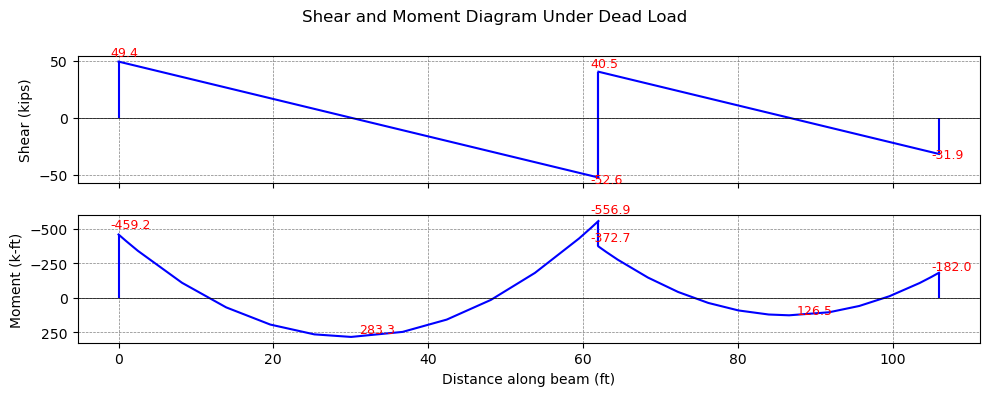

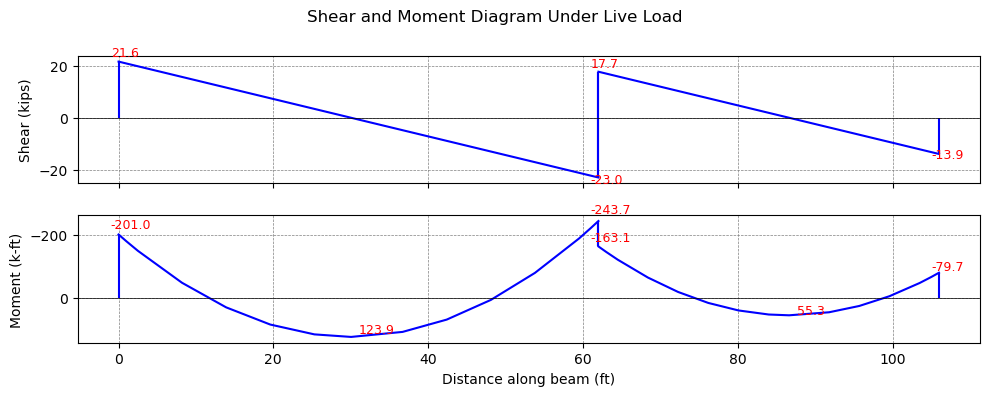

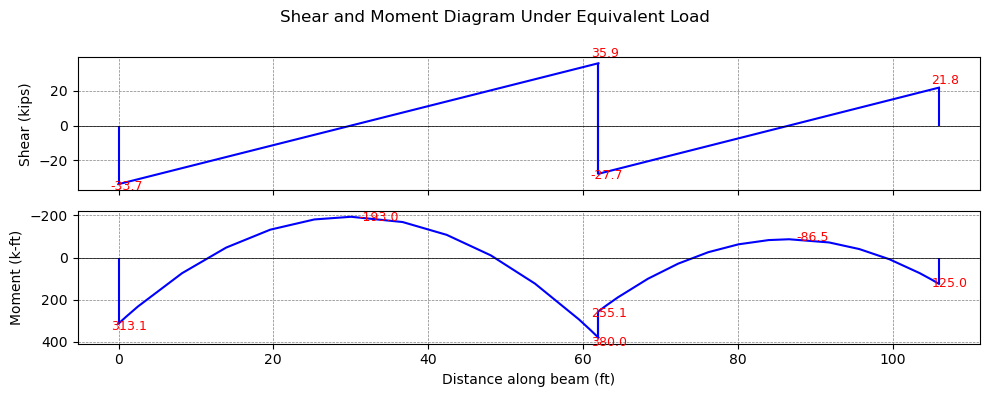

In [15]:
for load_case in uniform_loads.keys():
    plot_moment_shear_diagrams(
        beams, 
        X, {'Shear (kips)': V[load_case], 'Moment (k-ft)': M[load_case]}, 
        figsize=(10, 4), 
        title=f"Shear and Moment Diagram Under {load_case} Load")

### 5. Shear and Moment Values

In [16]:
# Concatenate results for all beams
dist_segments = []
shear, moment = {}, {}

for load_case in uniform_loads:
    # stack along beam axis first, then flatten
    shear[load_case] = np.hstack(V[load_case])
    moment[load_case] = np.hstack(M[load_case])

# build distance array with offsets
for i, beam in enumerate(beams):
    offset = sum(beam_lengths[:i])
    dist_segments.append(X[i] + offset)

dist = np.hstack(dist_segments)


# Create a dataframe to store x_coord, shear and moment for each load case
shear_moment_df = pd.DataFrame({
    "X (ft)": dist,
    "V_d (kips)": shear["Dead"],
    "M_d (k.ft)": moment["Dead"],
    "V_l (kips)": shear["Live"],
    "M_l (k.ft)": moment["Live"],
    "V_eql (kips)": shear["Equivalent"],
    "M_eql (k.ft)": moment["Equivalent"]
}).set_index("X (ft)")

shear_moment_df["V_s (kips)"] = shear_moment_df["V_d (kips)"] + shear_moment_df["V_l (kips)"] + shear_moment_df["V_eql (kips)"]
shear_moment_df["M_s (k.ft)"] = shear_moment_df["M_d (k.ft)"] + shear_moment_df["M_l (k.ft)"] + shear_moment_df["M_eql (k.ft)"]

# Set the dataframe to show all rows
pd.set_option('display.max_rows', None)
shear_moment_df.round(1)

,V_d (kips),M_d (k.ft),V_l (kips),M_l (k.ft),V_eql (kips),M_eql (k.ft),V_s (kips),M_s (k.ft)
X (ft),,,,,,,,
0.000000,49.4,-459.2,21.6,-201.0,-33.7,313.1,37.4,-347.1
1.000000,47.8,-410.6,20.9,-179.7,-32.6,280.0,36.1,-310.4
2.500000,45.3,-340.8,19.8,-149.2,-30.9,232.4,34.3,-257.6
8.200000,35.9,-109.2,15.7,-47.8,-24.5,74.5,27.2,-82.5
13.900000,26.6,68.9,11.6,30.1,-18.1,-46.9,20.1,52.1
19.600000,17.2,193.6,7.5,84.7,-11.7,-131.9,13.0,146.4
25.300000,7.8,264.8,3.4,115.8,-5.3,-180.4,5.9,200.2
30.042281,0.0,283.3,0.0,123.9,0.0,-193.0,0.0,214.2
36.700000,-11.0,246.8,-4.8,108.0,7.5,-168.1,-8.3,186.7


---

## Service Stresses

The stresses at service load shall be less than the following allowable stresses determined by ACI 318:

* Allowable tensile stress at service (Class U): $f_t \le 7.5 \sqrt{f'_c}$ [ACI 318-25, table 24.5.2.1]

* Allowable compressive stress at service: $0.60 f'_c$ [ACI 318-25, table 24.5.4.1]

In [17]:
# Allowable tensile stress at service per ACI 318-25 table 24.5.2.1 (uncracked, class U)
f_ta = 7.5 * np.sqrt(con_5000.fc) / 1000 # ksi

# Allowable compressive stress at service per ACI 318-25 table 24.5.4.1
f_ca = -0.6 * con_5000.fc / 1000 # ksi

print(f"Allowable tensile stress at service, f_ta = {f_ta:.3f} ksi")
print(f"Allowable compressive stress at service, f_ca = {f_ca:.3f} ksi\n")

service_shear = np.zeros_like(X, dtype=float)
service_moment = np.zeros_like(X, dtype=float)

for load_case in ["Dead", "Live", "Equivalent"]:
    service_shear += V[load_case]
    service_moment += M[load_case]

service_stress_top  = np.zeros_like(X, dtype=float)
service_stress_bot  = np.zeros_like(X, dtype=float)

row_idx = np.arange(n_beams)[:, None]
selected_idx = np.empty((n_beams, 3), dtype=int)
for i, beam in enumerate(beams):
    print(f"{beam.id}: A={beam.sec.area:.3f} ft2, St={beam.sec.section_modulus()['top']:.3f} ft3, Sb={beam.sec.section_modulus()['bottom']:.3f} ft3")
    
    selected_idx[i] = [1, np.argmin(np.abs(service_shear[i])), -2]
    
    service_stress_top[i] = (-service_moment[i] / beam.sec.section_modulus()['top'] - F / beam.sec.area) / 12**2  # convert ksf to ksi
    service_stress_bot[i] = (service_moment[i] / beam.sec.section_modulus()['bottom'] - F / beam.sec.area) / 12**2  # convert ksf to ksi

M_s = service_moment[row_idx, selected_idx].flatten()
sigma_st = service_stress_top[row_idx, selected_idx].flatten()
sigma_sb = service_stress_bot[row_idx, selected_idx].flatten()

print(f"\nService moment (k-ft):\t\t{M_s.round(1)}")
print(f"Service stress at top (ksi):\t{sigma_st.round(3)}")
print(f"Service stress at bottom (ksi):\t{sigma_sb.round(3)}")

Allowable tensile stress at service, f_ta = 0.530 ksi
Allowable compressive stress at service, f_ca = -3.000 ksi

B1: A=6.528 ft2, St=5.803 ft3, Sb=2.691 ft3
B2: A=6.528 ft2, St=5.803 ft3, Sb=2.691 ft3

Service moment (k-ft):		[-310.4  214.2 -381.5 -250.8   95.4 -113.3]
Service stress at top (ksi):	[ 0.088 -0.54   0.173  0.017 -0.397 -0.148]
Service stress at bottom (ksi):	[-1.084  0.27  -1.268 -0.93  -0.037 -0.576]


All the tensile and compressive stresses at service (Dead + Live + Equivalent) loads are less that the allowable stresses.

---

## Ultimate Stresses

### 1. Calculate Secondary Moments

In [18]:
# Eccentricities at supports
ecc_a = 0
ecc_b = beams[0].sec.yt - 4 / 12 # ft
ecc_c = 0

# Primary moments at supports
M_pa = F * ecc_a # k-ft
M_pb = -F * ecc_b # k-ft
M_pc = F * ecc_c # k-ft

# Equivalent moments at supports
M_eql_a = M["Equivalent"][0, 0]
M_eql_b_left = M["Equivalent"][0, -1]
M_eql_b_right = M["Equivalent"][1, 0]
M_eql_c = M["Equivalent"][1, -1]

# Secondary moments at supports
M_2a = M_pa + M_eql_a
M_2b_left = M_pb + M_eql_b_left
M_2b_right = M_pb + M_eql_b_right
M_2c = M_pc + M_eql_c

print(f"M_2a={M_2a:.1f} k-ft")
print(f"M_2b={M_2b_left:.1f} k-ft (left)")
print(f"M_2b={M_2b_right:.1f} k-ft (right)")
print(f"M_2c={M_2c:.1f} k-ft")

M_2a=313.1 k-ft
M_2b=215.7 k-ft (left)
M_2b=90.8 k-ft (right)
M_2c=125.0 k-ft


In [19]:
# Generate shear and moment values
secondary_moments = {
    "B1": (-M_2a, M_2b_left),
    "B2": (-M_2b_right, M_2c)
}

V2 = [None] * n_beams
M2 = [None] * n_beams

for j, beam in enumerate(beams):
    _, v, m = generate_shear_moment_diagrams(
        beam=beam,
        uniform_load=0,
        support_moments=secondary_moments[beam.id],
        n_points=N_POINTS,
    )
    V2[j] = v
    M2[j] = m
    
# Stack into (n_beams, N_POINTS)
V2 = np.stack(V2, axis=0) # kips, insignificant
M2 = np.stack(M2, axis=0) # k-ft, significant

shear_moment_df["V2 (kips)"] = np.hstack(V2)
shear_moment_df["M2 (k-ft)"] = np.hstack(M2)

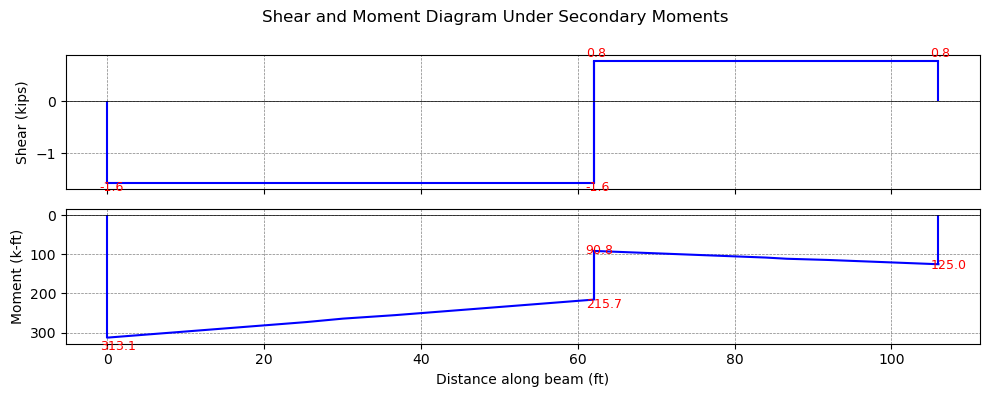

In [20]:
# Diagram under secondary loads
plot_moment_shear_diagrams(
    beams, 
    X, {'Shear (kips)': V2, 'Moment (k-ft)': M2},
    figsize=(10, 4),
    title="Shear and Moment Diagram Under Secondary Moments"
)

### 2. Calculate Demand Shear and Moment

In [21]:
shear_moment_df["M2 (k.ft)"] = V2.flatten()
shear_moment_df["M2 (k.ft)"] = M2.flatten()

# Calculate ultimate shear and moment
V_u = 1.2 * V["Dead"] + 1.6 * V["Live"] # kips
M_u = 1.2 * M["Dead"] + 1.6 * M["Live"] # k-ft

# Calculate demand shear and moment per ACI 318-25 section 5.3.14
V_dmd = V_u + V2 # kips
M_dmd = M_u + M2 # k-ft

shear_moment_df["V_u (kips)"] = V_u.flatten()
shear_moment_df["M_u (k-ft)"] = M_u.flatten()
shear_moment_df["V_dmd (kips)"] = V_dmd.flatten()
shear_moment_df["M_dmd (k-ft)"] = M_dmd.flatten()

shear_moment_df[["V_u (kips)", "M_u (k-ft)", "V_dmd (kips)", "M_dmd (k-ft)"]].round(1)

,V_u (kips),M_u (k-ft),V_dmd (kips),M_dmd (k-ft)
X (ft),,,,
0.000000,93.9,-872.6,92.4,-559.5
1.000000,90.8,-780.3,89.2,-468.7
2.500000,86.1,-647.6,84.5,-338.4
8.200000,68.3,-207.5,66.7,92.7
13.900000,50.5,130.9,48.9,422.2
19.600000,32.6,367.8,31.1,650.1
25.300000,14.8,503.1,13.3,776.5
30.042281,0.0,538.3,-1.6,802.7
36.700000,-20.8,469.0,-22.4,724.5


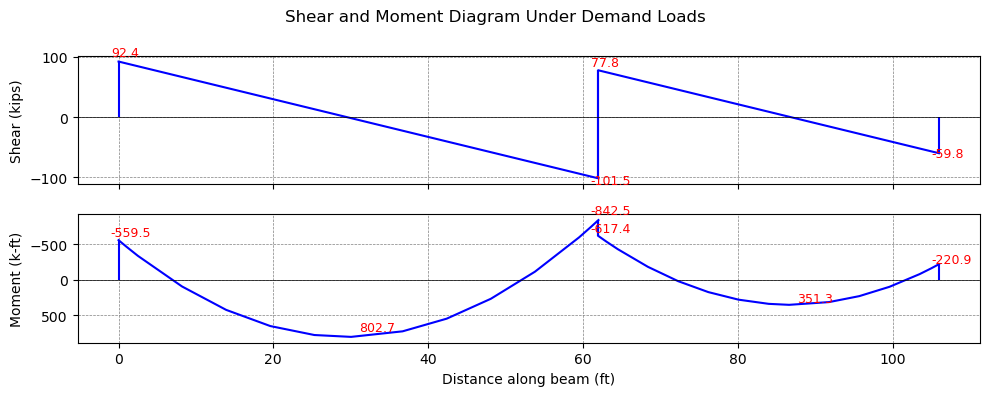

In [22]:
# diagram under demand loads
plot_moment_shear_diagrams(
    beams, 
    X, {'Shear (kips)': V_dmd, 'Moment (k-ft)': M_dmd},
    figsize=(10, 4),
    title="Shear and Moment Diagram Under Demand Loads"
)

In [23]:
for i, beam in enumerate(beams):
    print(f"M_demand of {beam.length}-ft beam:")
    print(f"\tLeft column face:\t {M_dmd[i, selected_idx[i, 0]]:.1f} k-ft")
    print(f"\tMid-span:\t\t {M_dmd[i, selected_idx[i, 1]]:.1f} k-ft")
    print(f"\tRight column face:\t {M_dmd[i, selected_idx[i, 2]]:.1f} k-ft\n")

M_demand of 62-ft beam:
	Left column face:	 -468.7 k-ft
	Mid-span:		 802.7 k-ft
	Right column face:	 -742.5 k-ft

M_demand of 44-ft beam:
	Left column face:	 -541.1 k-ft
	Mid-span:		 351.3 k-ft
	Right column face:	 -162.7 k-ft



---

### 3. Calculate Tendons Stress at Ultimate

* The tendon stress at ultimate is calculated per ACI 318-25, section 20.3.2.4.1.
* The following calculation is performed for the left side of support B (mid-support).

In [24]:
# Right column face of 66-ft beam

Aps = tendon.Aps # in^2

# Effective depth of tendon
dp = beams[0].depth * 12 - 4 # in

# prestressing reinforcement ratio
rho_p = Aps / (beams[0].width * dp * 12)

def get_prestressed_tendon_ultimate_stress(
    beam: Union[ConcreteRectangleBeam, ConcreteTSectionBeam], 
    tendon: PrestressingTendon, 
    concrete: ACIConcrete, 
    rho_p: Union[float, np.ndarray]) -> np.ndarray:
    """Compute tendon stress at ultimate limit state per ACI 318-25 section 20.3.2.4.1.
    
    Args:
        beam: Beam object.
        tendon: PrestressingTendon object.
        concrete: ACIConcrete object.
        rho_p: Prestressing reinforcement ratio.
        
    Returns:
        f_ps: Prestressing tendon stress at ultimate limit state (ksi).
    """
    if beam.length/beam.depth <= 35:
        f_ps1 = tendon.fse + 10e3 + concrete.fc / (100 * rho_p)  # psi
        f_ps2 = tendon.fse + 60e3  # psi
    else:
        f_ps1 = tendon.fse + 10e3 + concrete.fc / (300 * rho_p)  # psi
        f_ps2 = tendon.fse + 30e3  # psi

    return np.minimum(np.minimum(f_ps1, f_ps2), tendon.fpy) # psi

fps = get_prestressed_tendon_ultimate_stress(beams[0], tendon, con_5000, rho_p)
print(f"Beam {beam.id}:")
print(f"rho_o: {rho_p:.4f}")
print(f"fps: {fps:.1f} psi")

Beam B2:
rho_o: 0.0032
fps: 199686.3 psi


---

### 4. Determine Non-prestressing Reinforcement

Minimum non-prestressing reinforcement for beams, $A_{s,min}$, is determined per ACI 318-25, section 9.6.2.3

$$A_{s,min} = 0.004 A_{ct}$$

where &A_{ct}& is defined as the area of part of the cross section between the flexural tension face and centroid of the gross section. In this case since the moment is negative, $A_{ct}$ includes the beam flange plus a portion of the web.

In [25]:
# Calculate A_ct
flange_area = beams[0].flange_width * beams[0].flange_thickness * 12**2 # in^2
web_partial_area = (beams[0].sec.yt - beams[0].flange_thickness) * beams[0].width * 12**2 # in^2
A_ct = flange_area + web_partial_area # in^2
print(f"A_ct={A_ct:.1f} in^2")

# Calculate A_s_min per ACI 318-25 section 9.6.2.3
A_s_min = 0.004 * A_ct # in^2
print(f"A_s_min={A_s_min:.2f} in^2")

# Assume 3#8 tensile reinforcement
D8 = LongitudinalRebar(size=8, mat=mild_steel) # bar #8
As = 3 * D8.area # in^2
print(f"Provided tensile reinforcement: 3#8 (As={As:.2f} in^2 > A_s_min)")

A_ct=571.1 in^2
A_s_min=2.28 in^2
Provided tensile reinforcement: 3#8 (As=2.36 in^2 > A_s_min)


---

### 5. Compute Nominal Moment Capacity

In [26]:
# Compute forces in concrete and steel at ultimate state

# Tensile force in non-prestressing steel assuming it yields (eps_ts > eps_y)
Ts = As * D8.mat.fy / 1e3 # kips
print(f"Ts = {Ts:.1f} kips")

# Tensile force in prestressing steel
Tps = Aps * fps / 1e3 # kips
print(f"Tps = {Tps:.1f} kips")

# compute concrete compressive force using equilibrium
Cc = Ts + Tps # kips
print(f"Cc = {Cc:.1f} kips")

# Compute depth of the neutral axis from the compression face
a = 1e3 * Cc / (0.85 * con_5000.fc * (beams[0].width * 12)) # in
c = a / con_5000.beta_1 # in
print(f"a = {a:.3f} in")
print(f"c = {c:.3f} in")


COVER = 1.5 # in, rebar cover
D3 = TransverseRebar(size=3, mat=mild_steel, nLegsX=2, nLegsY=2, spacing=6) # stirrup #3

# Effective depth of the nonprestressing tensile reinforcement
d = beams[0].depth * 12 - COVER - D3.dia - D8.dia / 2 # in

# Compute nominal moment capacity assumin eps_ts > 0.005
M_n = Ts * (d - a / 2) / 12 + Tps * (dp - a / 2) / 12 # k-ft
phi = 0.9
print(f"phi*M_n = {phi*M_n:.1f} k-ft")
print(f"M_demand = {abs(M_dmd[0, -2]):.1f} k-ft < phi*M_n, OK")


Ts = 141.4 kips
Tps = 305.5 kips
Cc = 446.9 kips
a = 7.010 in
c = 8.763 in
phi*M_n = 972.3 k-ft
M_demand = 742.5 k-ft < phi*M_n, OK


---

### 6. Compute Strains

To versity the assumptions regarding the yielding of tensile steel, I need to compute the strains of tensile reinforcement.

In [27]:
# Concrete ultimate strain
eps_cu = abs(con_5000.eps_u) # 0.003

# Strain of tensile reinforcement at nominal flexural strength
eps_ts = (d - c) / c * eps_cu

print(f"eps_ts = {eps_ts:.4f} > 0.005 > eps_y, OK")

eps_ts = 0.0085 > 0.005 > eps_y, OK


---

### 7. Check Flexural Strength at Other Sections (in progress)

In [28]:
l_ab = beams[0].length # ft
l_mask = dist <= l_ab

# Compute c.g.s. of tendon from c.g.c.
cgs = np.empty_like(dist, dtype=float)
cgs[l_mask] = np.polyval([a1, b1, c1], dist[l_mask])
cgs[~l_mask] = np.polyval([a2, b2, c2], dist[~l_mask])

# Compute effective depth of tendon from compression face, dp (inches)
dp = np.where(
    M_dmd.flatten() > 0,
    np.where(
        dist <= beams[0].length,
        beams[0].sec.yt * 12 - cgs,
        beams[1].sec.yt * 12 - cgs
    ), np.where(
        dist <= beams[0].length,
        beams[0].sec.yb * 12 + cgs,
        beams[1].sec.yb * 12 + cgs
    )
)

# Compute prestressing reinforcement ratio, rho_p
rho_p = np.where(
    M_dmd.flatten() > 0,
    np.where(
        dist <= beams[0].length,
        Aps / (beams[0].flange_width * dp * 12),
        Aps / (beams[1].flange_width * dp * 12)
    ), np.where(
        dist <= beams[0].length,
        Aps / (beams[0].width * dp * 12),
        Aps / (beams[1].width * dp * 12)
    )
)

# Compute ultimate prestressing tendon stress, f_ps
fps = get_prestressed_tendon_ultimate_stress(beams[0], tendon, con_5000, rho_p) / 1e3 # ksi

# TODO:
# Compute A_s_min = 0.004 * A_ct
# Compute Ts, Tps, Cc assmuing eps_ts > eps_y
# Compute a, c
# Compute eps_ts to check the above assumption
# Compute M_n assuming eps_ts > 0.005
# Compute phi*M_n and compare with M_demand


In [29]:
flexural_df = pd.DataFrame({
    "X (ft)": dist.round(3),
    "M_dmd (k-ft)": M_dmd.flatten().round(1),
    "CGS (in)": cgs.round(2),
    "dp (in)": dp.round(2),
    "rho_p": rho_p.round(4),
    "fps (ksi)": fps.round(1)
}).set_index("X (ft)")

flexural_df

,M_dmd (k-ft),CGS (in),dp (in),rho_p,fps (ksi)
X (ft),,,,,
0.000,-559.5,0.00,24.60,0.0041,196.1
1.000,-468.7,-1.41,23.18,0.0044,195.4
2.500,-338.4,-3.44,21.16,0.0048,194.4
8.200,92.7,-10.11,21.51,0.0007,234.0
13.900,422.2,-15.15,26.55,0.0006,234.0
19.600,650.1,-18.55,29.95,0.0005,234.0
25.300,776.5,-20.32,31.72,0.0005,234.0
30.042,802.7,-20.55,31.95,0.0005,234.0
36.700,724.5,-18.96,30.36,0.0005,234.0


## Shear Design